<a href="https://colab.research.google.com/github/CyOwl-V/IDS-Project/blob/main/zeek%2BRandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
cd'/content/gdrive/MyDrive/Colab Notebooks/zeek'

/content/gdrive/MyDrive/Colab Notebooks/zeek


In [ ]:

# ایمپورت pandas
import pandas as pd

# تابع برای خواندن فایل Zeek conn.log
def parse_connlog(path):
    with open(path) as f:
        lines = f.readlines()

    # پیدا کردن خطی که اسامی ستون‌ها را دارد
    cols = []
    for line in lines:
        if line.startswith("#fields"):
            cols = line.strip().split("\t")[1:]  # حذف "#fields"
            break

    # خواندن داده‌های بدون خط‌های کامنت (#)
    data = [line.strip().split("\t") for line in lines if not line.startswith("#")]

    # ساخت DataFrame
    df = pd.DataFrame(data, columns=cols)
    return df

# خواندن دو فایل conn.log
df_normal = parse_connlog("conn-normal.log")
df_ddos = parse_connlog("conn-ddos.log")



In [ ]:
# ذخیره‌سازی داده‌ها به فرمت CSV
def save_to_csv():
    # خواندن دو فایل conn.log
    df_normal = parse_connlog("conn-normal.log")
    df_ddos = parse_connlog("conn-ddos.log")

    # ذخیره داده‌ها به فرمت CSV
    df_normal.to_csv("conn-normal.csv", index=False)
    df_ddos.to_csv("conn-ddos.csv", index=False)

# فراخوانی تابع برای ذخیره‌سازی فایل‌های CSV
save_to_csv()


In [ ]:
# نمایش ۵ سطر اول هر فایل
print("✅ نمونه‌ای از ترافیک نرمال:")
print(df_normal.head())

print("\n✅ نمونه‌ای از ترافیک DDoS:")
print(df_ddos.head())


✅ نمونه‌ای از ترافیک نرمال:
                  ts                 uid        id.orig_h id.orig_p  \
0  1746614020.759923  Cvfap41RFDaLCazYn4  192.168.159.128     44300   
1  1746614027.671921  CF15Zg2KEbRJ9UIxhl  192.168.159.128     52416   
2  1746614027.672127  CPZ0Ad48AXRuMkxR42  192.168.159.128     58392   
3  1746614032.677563  CbYx0c4ygQHUo9rCh2  192.168.159.128     48564   
4  1746614037.784046  CoqgMI1MMzDNN2V18i  192.168.159.128     48564   

       id.resp_h id.resp_p proto service  duration orig_bytes  ... local_orig  \
0  192.168.159.1        53   tcp       -  4.096057          0  ...          T   
1  192.168.159.1        53   udp     dns         -          -  ...          T   
2  192.168.159.1        53   udp     dns         -          -  ...          T   
3  192.168.159.1        53   tcp       -  4.082357          0  ...          T   
4  192.168.159.1        53   tcp       -  2.048237          0  ...          T   

  local_resp missed_bytes history orig_pkts orig_ip_bytes 

In [ ]:
# پیش‌پردازش ویژگی‌ها و تبدیل به عدد
def preprocess(df):
    return df[["duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]].apply(pd.to_numeric, errors="coerce").fillna(0)

# اعمال پیش‌پردازش روی داده‌های نرمال و ddos
X_normal = preprocess(df_normal)
X_ddos = preprocess(df_ddos)

# افزودن برچسب
X_normal["label"] = 0  # ترافیک نرمال
X_ddos["label"] = 1    # ترافیک حمله

# ترکیب داده‌ها
data = pd.concat([X_normal, X_ddos], ignore_index=True)

# جدا کردن ویژگی‌ها و برچسب
X = data.drop("label", axis=1)
y = data["label"]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# فرض: X = ویژگی‌ها، y = برچسب‌ها (label)

# تقسیم داده به آموزش و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# آموزش مدل Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# پیش‌بینی روی داده تست
y_pred = clf.predict(X_test)

# نمایش گزارش عملکرد
print(" گزارش عملکرد مدل:")
print(classification_report(y_test, y_pred))


 گزارش عملکرد مدل:
              precision    recall  f1-score   support

           0       0.93      0.19      0.31       221
           1       1.00      1.00      1.00    172751

    accuracy                           1.00    172972
   macro avg       0.97      0.59      0.65    172972
weighted avg       1.00      1.00      1.00    172972



In [ ]:
import joblib

# ذخیره مدل
joblib.dump(clf, "model.pkl")

['model.pkl']

In [ ]:
from google.colab import files
files.download("model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

total = tn + fp + fn + tp

print(f"True Positives (TP): {tp / total * 100:.2f}%")
print(f"False Positives (FP): {fp / total * 100:.2f}%")
print(f"True Negatives (TN): {tn / total * 100:.2f}%")
print(f"False Negatives (FN): {fn / total * 100:.2f}%")


True Positives (TP): 99.87%
False Positives (FP): 0.10%
True Negatives (TN): 0.02%
False Negatives (FN): 0.00%


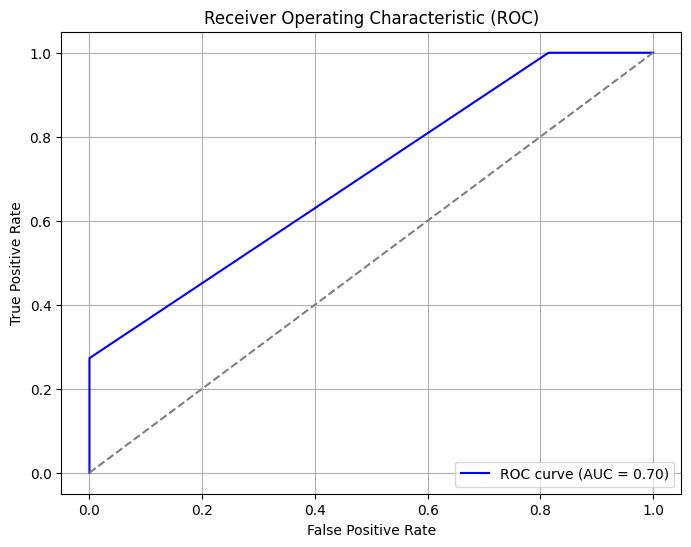

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [22]:
def read_zeek_log(path):
    with open(path, 'r') as f:
        lines = f.readlines()

    # پیدا کردن هدر (خطی که با '#fields' شروع می‌شه)
    header_line = None
    for line in lines:
        if line.startswith("#fields"):
            header_line = line
            break

    if not header_line:
        raise ValueError("No #fields line found in Zeek log!")

    # گرفتن اسم ستون‌ها
    columns = header_line.strip().split()[1:]

    # حذف خطوط meta و فقط داده‌ها رو نگه دار
    data_lines = [line.strip().split("\t") for line in lines if not line.startswith("#")]

    # ساخت دیتافریم
    df = pd.DataFrame(data_lines, columns=columns)
    return df

# استفاده:
df = read_zeek_log("conn-pro.log")
print(df.columns.tolist())  # ستون‌ها رو ببین


['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'ip_proto']


In [24]:
import joblib

clf = joblib.load("model.pkl")


In [25]:
features = ["duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]
X_new = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)

# اگر مدل قبلاً آموزش داده شده:
y_pred = clf.predict(X_new)
df["prediction"] = y_pred


In [26]:
# شمارش تعداد نمونه‌ها بر اساس برچسب پیش‌بینی‌شده
counts = df["prediction"].value_counts()

# تبدیل به درصد
percentages = counts / counts.sum() * 100

# نمایش
for label, pct in percentages.items():
    status = "🔴 ناهنجار (DDoS)" if label == 1 else "🟢 نرمال"
    print(f"{status}: {pct:.2f}%")


🔴 ناهنجار (DDoS): 94.09%
🟢 نرمال: 5.91%
